# FINM 35700 - Spring 2023

## Final exam: May 23 2023 - from 6pm to 8:45pm

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on following symbology & data files, as of 2023-05-19.

US government bonds:
- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,

Corporate bonds:
- the corporate  bonds symbology file (LQD constituents + AT&T bonds) `lqd_corp_symbology`
- the LQD ETF basket composition file `lqd_basket_composition`
- AT&T bond portfolio notionals: `att_bond_portoflio`

Market data:
- the cash bond market data file (US Treasuries + AT&T bonds) `market_prices_eod`,


## Scoring: Total of 125 points

| Problem | Points |
|---------|--------|
| 1       | 20     |
| 2       | 20     |
| 3       | 30     |
| 4       | 30     |
| 5       | 25     |
| Total   | 125    |

-----------------------------------------------------------------------------------------
# Collection of useful calibration helper functions from previous homeworks

In [2]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Enter the filepath to the data here.
FILEPATH = '../data/'

In [2]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")


def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule


def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported day count, {type(details['dcc'])}, {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date):
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    day_counter = bond.dayCounter()    
    
    x = [(cf.date(), day_counter.yearFraction(calc_date, cf.date()), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_yearFrac, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowYearFrac': cf_yearFrac, 'CashFlowAmount': cf_amount})

    # filter for payment dates > calc_date
    cashflows_df = cashflows_df[cashflows_df.CashFlowYearFrac > 0]
    return cashflows_df


def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''        
    if(maturity == 0 or params[3] <= 0):
        slope_1 = 1
        curvature = 0
    else:
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
        curvature = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature
    
    return total_value

def create_nelson_siegel_curve(calc_date, nelson_siegel_params):
    ''' nelson_siegel_params = (theta1, theta2, theta3, lambda)'''            
    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]
    
    # cap and floor survival probs
    nelson_siegel_surv_prob_levels = [max(min(x,1),1e-8) for x in nelson_siegel_surv_prob_levels]

    # nelson_siegel_surv_prob_curve
    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)
    
    return(nelson_siegel_credit_curve_handle)


def calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # nelson_siegel_surv_prob_curve_handle
    nelson_siegel_surv_prob_curve_handle = create_nelson_siegel_curve(calc_date, nelson_siegel_params)
    
    # nelson_siegel_risky_bond_engine
    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_surv_prob_curve_handle, bond_recovery_rate, tsy_yield_curve_handle)
    
    bond_model_prices = []
    bond_model_yields = []
    
    for fixed_rate_bond in fixed_rate_bond_objects:
        fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)
        
        bond_price = fixed_rate_bond.cleanPrice()                
        bond_yield = fixed_rate_bond.bondYield(bond_price, fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual) * 100
        
        bond_model_prices.append(bond_price)
        bond_model_yields.append(bond_yield)
    
    return(bond_model_prices, bond_model_yields)

def nelson_siegel_sse(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      market_prices, 
                      calib_weights,
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # bond_model_prices
    bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate)
    # sse    
    sse = 0
    
    for i in range(len(market_prices)):
        model_error = market_prices[i] - bond_model_prices[i]                
        sse += abs(model_error) * calib_weights[i]                        
    
    return(sse)    


def create_bonds_and_weights(bond_details, tsy_yield_curve_handle):
    
    # risk_free_bond_engine
    risk_free_bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_handle)


    fixed_rate_bond_objects = []
    bond_market_prices = []    
    bond_yields = []
    bond_DV01s = []    
    bond_durations = []    
    
    for index,row in bond_details.iterrows():
        fixed_rate_bond = create_bond_from_symbology(row)
        fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
        
        fixed_rate_bond_objects.append(fixed_rate_bond)
        
        bond_price = row['market_price']                
        bond_yield = fixed_rate_bond.bondYield(bond_price, fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual) * 100
        bond_yield_rate = ql.InterestRate(bond_yield/100, fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
        bond_duration = ql.BondFunctions.duration(fixed_rate_bond, bond_yield_rate)
        bond_DV01   = fixed_rate_bond.dirtyPrice() * bond_duration
        
        bond_market_prices.append(bond_price)
        bond_yields.append(bond_yield)
        bond_DV01s.append(bond_DV01)
        bond_durations.append(bond_duration)   
        
    # calib_weights: down-weight durations < 2 years, since the calibrated US treasury does not have quotes before 2Y
    calib_weights = [1 / max(d, 2) for d in bond_durations]
    sum_calib_weights = sum(calib_weights)
    calib_weights = [x / sum_calib_weights for x in calib_weights]
    
    return(fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations)

def calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_details, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4):
    # create_bonds_and_weights
    fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(bond_details, tsy_yield_curve_handle)
    
    # start calibration
    param_bounds = [(1e-3, 0.1), (-0.1, 0.1), (-0.1, 0.1), (1e-3, 10)]
            
    calib_results = minimize(nelson_siegel_sse,
                                            initial_nelson_siegel_params, 
                                            args = (calc_date, 
                                                    fixed_rate_bond_objects, 
                                                    bond_market_prices, 
                                                    calib_weights,
                                                    tsy_yield_curve_handle, 
                                                    bond_recovery_rate),
                                            bounds = param_bounds)


    return(calib_results)



------------------------------------------------------------------------------------------
# Problem 1: Overall understanding of credit market models (20 points)
## When answering the individual questions, you should assume 'ceteris paribus' - all else being equal.

## a. Fixed rate bond prices in the hazard rate model: True or False (5 points)

### - Use flat hazard rate model formula [54] in Lecture 4 to confirm your intuition - 

1. Fixed rate bond price is increasing in interest rate
1. Fixed rate bond price is increasing in hazard rate
1. Fixed rate bond price is increasing in expected recovery rate
2. Fixed rate bond price is increasing in coupon
3. Fixed rate bond price is increasing in bond maturity

## b. Fixed rate bond yields in the hazard rate model: True or False (5 points)

1. Fixed rate bond yield is increasing in interest rate
1. Fixed rate bond yield is increasing in hazard rate
1. Fixed rate bond yield is increasing in expected recovery rate
2. Fixed rate bond yield is increasing in coupon
3. Fixed rate bond yield is increasing in bond maturity

## c. Equity and equity volatility in the Merton Structural Credit Model: True or False (5 points)

### - Think about the equity value as a "call option on assets with liabilities as strike and use formulas [19] and [22] from Lecture 4" -

1. Equity value is increasing with company assets
2. Equity volatility is increasing with company assets
3. Equity value is increasing with assets volatility
4. Equity value is increasing with company liabiliites
5. Equity volatility is increasing with company liabiliites

## d. Yield and expected recovery rate in the Merton Structural Credit Model: True or False (5 points)

1. Yield is increasing with company liabilities
2. Expected recovery rate is increasing with company liabilities
3. Yield is increasing with assets volatility
4. Credit spread is increasing with asset values
5. Credit spread is increasing with assets volatility


-----------------------------------------------------------
# Problem 2: Scenario analysis for a fixed rate corporate bond (yield model) (20 points)
## Use the QuantLib Introductory notebook (or any of the homeworks) as a template.

## a. Create generic fixed-rate corporate bond (5 points)
Fixed the calculation date of May 19 2023 (last Friday) and use a coupon of 5% and a maturity of 10 years (May 19 2039).

Display the fixed rate bond cashflows.

In [3]:
# Use static calculation/valuation date of 2023-05-19, matching data available in the market prices EOD file
calc_date = ql.Date(19, 5, 2023)
ql.Settings.instance().evaluationDate = calc_date

# used to identify calc date in market data frames
calc_date_str = '2023-05-19'

In [4]:
# Use the bond_details template below to quickly define the bond specs
test_bond_details = {'start_date': 'YYYY-MM-DD', 
                'acc_first': 'YYYY-MM-DD', 
                'maturity': 'YYYY-MM-DD', 
                'coupon': 3.55,
                'dcc' : '30/360',
                'days_settle' : 2}

# Use create_bond_from_symbology() to create the bond

## b. Compute the bond price, DV01, duration and convexity (analytic method). (5 points)

The market yield of the bond is 6%. Compute the bond price, DV01, duration and convexity, using the analytic method.

## c. Scenario bond prices: "analytic re-pricing" vs "second-order approximations" (5 points)

Compute the scenario bond prices on the following scenario yield grid: [from 2% to 10% in steps of 0.5%]

Compute the second-order scenario price approximations using duration and convexity sensitivities.

Plot the scenario prices (Y-axis) vs yieds (X-axis), for both the "analytic re-pricing" and "second-order approximations" method.

## d. Extreme events scenarios (5 points)

Compute and show the scenario bond price for a bond yield of 15% (extreme event scenario).

Compute and show the second-order scenario price approximation in the extreme event scenario.

How accurate is the second-order scenario price approximations (using duration and convexity sensitivities)?

Compute and show the analytic DV01, duration and convexity in the extreme event scenario.

-----------------------------------------------------------
# Problem 3: LQD basket analysis - pricing and bucketed interest rate hedging (30 points)

## Use the solution from Homework 5 Problem 5 as a template.

## a. Load and explore the LQD basket composition and market data (5 points)

Load the `lqd_basket_composition` Excel file into a dataframe. It contains the LQD basket constituent face notionals, weights and yields-to-maturities as of 2023-05-19.

The `corp_symbology` dataframe contains the corporate bond details for LQD constituents (as well as other bonds needed for Problem 4). 

Merge the two dataframes (inner join) into a combined LQD dataframe.

How many corporate bonds are in the LQD basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the LQD basket? What are the average and median face notionals by ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.


## b. Compute the NAV of the LQD basket on $100 face notional. (5 points)

Create the bond objects for all constituents of LQD. Compute the dirty price for each bond (from yield-to-maturity in the `lqd_basket_composition` dataframe).

Aggregate the ETF NAV value (intrisic value of bond basket) as the weighted sum of dirty prices times basket weights. Keep in mind that the resulting ETF NAV will be on a face of $100, since the basket face notional weights add up to 100 percent.

## c. Compute the intrinsic price of one LQD ETF share. (5 points)

Compute the intrinisc market capitalization of the LQD ETF by scaling the ETF NAV price to the ETF total face notional. 

Divide by 328,600,000 (the number of LQD shared outstanding as of 2023-05-19) to obtain the intrinsic price of one LQD ETF share.

## d. Compute the scenario DV01s of the Benchmark US Treasuries (5 points)

Use the `und_bench_tsy_isin` column in the bond symbology dataframe to find the Benchmark US Treasuries used for bucketed hedging in the LQD portfolio (there should be 7 of them). 

Compute the scenario DV01 for each Benchmark US Treasury (bump the yield by -1 bp and re-price the bond).


## e. Compute the bucketed interest rate DV01s and hedging notionals in terms of benchmark treasuries. (5 points)

For each bond:
1. Compute the DV01, using either the analytic or scenario method. 
2. Identify the Benchmark US Treasury (via the `security` column) which will be used to hedge the interest rate exposure of the corporate bond.
3. Compute the hedge notional in the Benchmark US Treasury, using the ratio of corporate bond DV01 over Benchmark Treasury DV01.

Extend the LQD combined dataframe with the following columns:


| dv01 |  und_bench_tsy_security | und_bench_tsy_dv01 | und_bench_tsy_hedge_notional |
|----------|-------------|-------|-------------|

where

- dv01 = corporate bond DV01
- und_bench_tsy_security = Underlying Benchmark US Treasury `security` name
- und_bench_tsy_dv01 = Underlying Benchmark US Treasury DV01
- und_bench_tsy_hedge_notional = dv01 / und_bench_tsy_dv01


## f. Compute the bucketed interest rate DV01 and hedging notionals for the LQD ETF basket. (5 points)

Compute interest rate DV01 exposure of the LQD ETF NAV (on a face of $100) to the 7 benchmark treasury buckets.

Compute interest rate hedging notionals of the LQD ETF NAV (on a face of $100) to the 7 benchmark treasury buckets.

What treasury notionals (in the 7 Benchmark US Treasuries) are needed for a bucketed interest rate hedge of 100,000 shares of LQD? Display the results.


--------------------------------------------------------------------------------------
# Problem 4: Portfolio risk analysis in the Nelson-Siegel model (30 points)

## Use the solution code from Homework 4 Problem 3 as a template !

## a. Prepare the symbology + market data (5 points)
Load and merge the symbology + market data dataframes for all AT&T fixed rate corporate bonds (ticker = 'T') as of 2023-05-19. 

Calibrate the "on-the-run" US Treasury curve as of 2023-05-19 (using code from previous homeworks).

## b. Calibrate the Nelson-Siegel smooth AT&T credit curve in hazard rate space (5 points)

Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.


## c. Compute Nelson-Siegel model prices, yield and edges for individual bonds. (5 points)

Price all AT&T bonds on the calibrated credit curve and compute the model prices and yields.

Plot the model vs market yields (Y-axis) by time to maturity (X-axis).

Plot the edges in yield space (Y-axis) by time to maturity (X-axis).

## d. Load the AT&T bond portfolio and compute the aggregated model edge in the portfolio (5 points)

Load the bond portfolio positions file `bond_portoflio_att`, which contains long and short positions in AT&T bonds. 

Comput the total/aggregated "model edge" in the portfolio.

## e. Compute sensitivities to the Nelson-Siegel "credit curve shape" model parameters (5 points)

Create the following Nelson-Siegel scenario credit curves:
1. Parallel shift (credit level change) scenario in hazard rate curve: bump $\theta_1$ model parameter by 1bp
1. Steepener (credit slope change) scenario in hazard rate curve: bump $\theta_2$ model parameter by 1bp
1. Curvature (credit convexity change) scenario in hazard rate curve: bump $\theta_3$ model parameter by 1bp

For each bond, compute the model prices and corresponding factor sensitivites in the three scenarios:
* Credit_Level_01 = $\frac{\partial B}{\partial \theta_1}$, 
* Credit_Slope_01  = $\frac{\partial B}{\partial \theta_2}$ and 
* Credit_Convexity_01  = $\frac{\partial B}{\partial \theta_3}$.

Display the sensitivities for the first 5 bonds in the AT&T dataframe.

## f. Compute portfolio factor sensitivities (5 points)

Compute the model parameter sensitivities (factor exposures) of the `bond_portoflio_att` portfolio:
* Portfolio Credit_Level_01 = change in portfolio value for a 1bp change in $\theta_1$ model parameter.
* Portfolio Credit_Slope_01 = change in portfolio value for a 1bp change in $\theta_2$ model parameter.
* Portfolio Credit_Convexity_01 = change in portfolio value for a 1bp change in $\theta_3$ model parameter.

------------------------------------------------------------------
# Problem 5: Derivation of prices and factor sensitivities (25 points)

Starting from the fair value formulas for risky fixed rate bonds, derive the formulas for factor sensitivities.

Assume flat model parameters, T+0 settlement and zero accrued. Use the 'sympy' library (for symbolic mathematics) for help with the derivation of the formulas, as described in the the solution to Homework 3, Problem 2.

For results visualization via 3D surface plots, you can use the matplotlib plot_surface() function or similar.

### Part 1. Flat Yield Model 
### Parameters:
* maturity T (in years),
* semi-annual coupon c,
* flat bond yield y

According to formula (4) in Session 1, the bond present value is given by:

\begin{align}
RickyBondPV=B(0,T,c,y)
\end{align}

\begin{align}
=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}}+e^{-T\cdot y}
\end{align}

\begin{align}
= 1+\left(\frac{c}{2 \cdot \left( e^{\frac{y}{2}}-1 \right) } -1 \right) \cdot \left(1-e^{-T\cdot y}\right)
\end{align}


The code below implements the present value function for a fixed rate bond.

It uses the 'sympy' library (symbolic mathematics) to translate mathematical formulas into function, as described in the solution to Homework 3, Problem 2.

For plotting, we fix the bond coupon c at 5% and use the following discretization grids:
* in yield space: [y from 0% to 10% in steps of 0.5%] and 
* in time-to-maturity space: [T from 1Y to 20Y in steps of 1Y].


In [6]:
# import libraries
import sympy as sp

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

# define symbolic variables
T = sp.symbols('T')
c = sp.symbols('c')
y = sp.symbols('y')

# define symbolic equation for bond pv
bond_pv_eq =  1 + (c/2  / (sp.exp(y/2) - 1) - 1 )* (1 - sp.exp(-T*y))
print('Analytic formula for bond_pv:', bond_pv_eq)
display(bond_pv_eq)

# create function from equation
bond_pv_func = sp.lambdify([c,T,y], bond_pv_eq)

# sample_bond_pv (for c = 5%, T = 10 and y = 7%)
sample_bond_pv = round(bond_pv_func(0.05, 10, 0.07) * 100, 2)
print('Sample bond_pv (for coupon = 5%, T = 10 and y = 7%):', sample_bond_pv)

Analytic formula for bond_pv: (1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1


(1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1

Sample bond_pv (for coupon = 5%, T = 10 and y = 7%): 84.99


Text(0.5, 0, 'Bond Price')

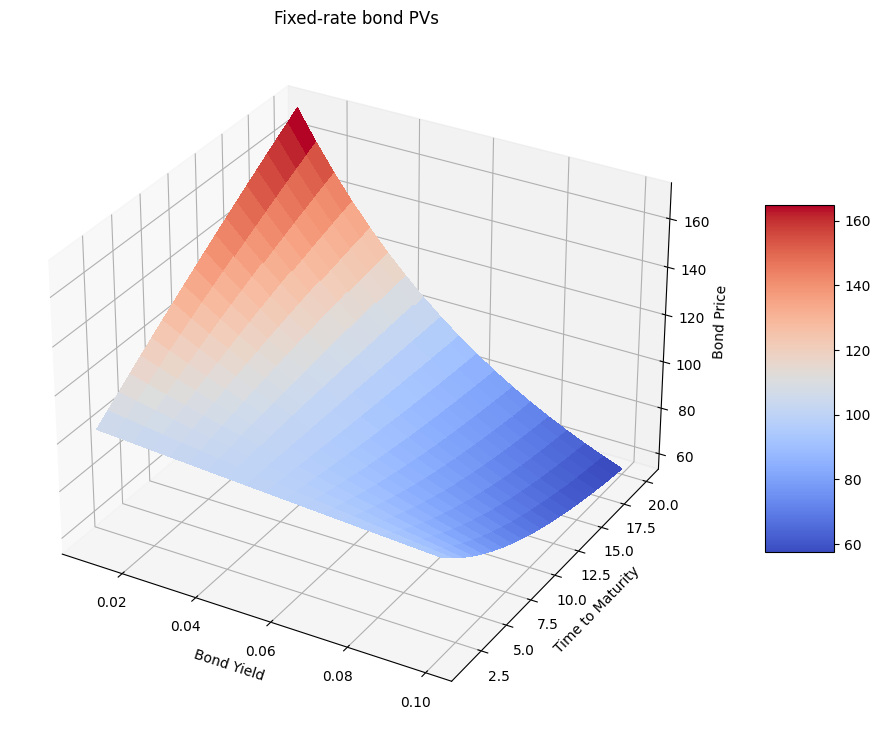

In [7]:
import numpy as np

coupon = 0.05

y_grid = np.arange(0.01, 0.105, 0.005)
T_grid = np.arange(1, 21, 1)

X, Y = np.meshgrid(y_grid, T_grid)
Z = X.copy()

# Plot the fixed-coupon bond price surface by y and T.
for i in range(len(T_grid)):
    for j in range(len(y_grid)):
        Z[i,j] = bond_pv_func(coupon, Y[i,j], X[i,j]) * 100

# Creating figure
fig = plt.figure(figsize =(16, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('Fixed-rate bond PVs')

ax.set_xlabel('Bond Yield')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Bond Price')

## a. Derive and implement the analytic formula for bond duration. (5 points)

Use the sympy "diff()" function to compute firt order derivatives, as explained in the solution to Homework 3, Problem 2c.

Plot the bond duration surface by t and T.

## b. Derive and implement the analytic formula for bond convexity.  (5 points)

Plot the bond convexity surface by t and T.

## Part 2: Flat Hazard Rate Model
## Parameters:
* maturity T (in years),
* semi-annual coupon c,
* flat interest rate r
* flat hazard rate h
* expected recovery rate R

According to formula (42) in Session 3, the risky bond present value is given by:

\begin{align}
RiskyBondPV=B(0,T,c,r,h,R)
\end{align}

\begin{align}
=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\left(r+h\right)/2}+R \cdot \int_{t}^{T} h \cdot e^{- \left( t - s \right) \cdot \left(r+h\right)} \cdot ds
\end{align}


\begin{align}
= 1+\left[ \frac{c}{2 \cdot \left( e^{\frac{r+h}{2}}-1 \right) } -1 +\frac{R\cdot h}{r+h}\right] \cdot \left(1-e^{-T\cdot \left( r+h \right)}\right)
\end{align}


For results visualization, fix the bond coupon c at 5%, maturity T at 10 years and interest rates r at 4%. 

Use discretization grids [h from 1% to 10% in steps of 0.5%] and [R from 5% to 100% insteps of 5%] for 3D plotting.

## c. Fixed rate bond valuation in hazard rate model  (5 points)

Implement the present value formula for the fixed rate bond.

Plot the PV surface by h and R.



## d. Derive and implement the analytic formula for bond IR01.   (5 points)
 Use the price derivative with respect to interest rate r to obtain the bond IR01.

Plot the IR01 surface by h and R.

## e. Derive and implement the analytic formula for bond HR01  (5 points)
Use the price derivative with respect to hazard rate h to obtain the bond HR01.

Plot the HR01 surface by h and R.